In [68]:
# !pip install cfgrib xarray matplotlib pandas
# !pip install dask
# !pip install seaborn
# !pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 2.4 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/9.8 MB 2.8 MB/s eta 0:00:04
   ------ --------------------------------- 1.6/9.8 MB 2.7 MB/s eta 0:00:04
   -------- ------------------------------- 2.1/9.8 MB 2.9 MB/s eta 0:00:03
   ----------- ---------------------------- 2.9/9.8 MB 2.8 MB/s eta 0:00:03
   ------------- -------------------------- 3.4/9.8 MB 2.8 MB/s eta 0:00:03
   ----------------- ---------------------- 4.2/9.8 MB 2.9 MB/s eta 0:00:02
   ------------------- -------------------- 4.7/9.8 MB 3.0 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.8 MB 2.8 MB/s eta 0:00:02
   ------------------------ --------------- 6.0/9.8 MB 2.9 MB/s eta 0:00:02
   --------------------------- ------------ 6.8/9.8 MB 3.0 MB/s eta 0:00:01
   ------------------------------ --------- 7.6/9.8 MB 3.1 MB/s eta 0:00:01
   ----------------

In [69]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import cfgrib
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

### ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib

#### Combine Datasets in one List

In [56]:
file_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib"

# Replace backslashes with forward slashes
updated_path = file_path.replace('\\', '/')

# Print the updated path
print("Original Path:", file_path)
print("Updated Path:", updated_path)

# Use open_datasets and NO open_dataset(from Error)
datasets = cfgrib.open_datasets(updated_path)
print(datasets)


Original Path: C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib
Updated Path: C:/Users/giann/OneDrive/Desktop/Thesis/Copernicus_Data/ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib
[<xarray.Dataset> Size: 220MB
Dimensions:              (time: 528, latitude: 153, longitude: 341)
Coordinates:
    number               int32 4B 0
  * time                 (time) datetime64[ns] 4kB 2013-01-01 ... 2023-12-01T...
    step                 timedelta64[ns] 8B 00:00:00
    depthBelowLandLayer  float64 8B 0.0
  * latitude             (latitude) float64 1kB 72.0 71.75 71.5 ... 34.25 34.0
  * longitude            (longitude) float64 3kB -25.0 -24.75 ... 59.75 60.0
    valid_time           (time) datetime64[ns] 4kB 2013-01-01 ... 2023-12-01T...
Data variables:
    swvl1                (time, latitude, longitude) float32 110MB ...
    stl1                 (time, lati

#### Data Cleaning

In [57]:
# Path to the folder containing the .nc files
folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023"

# Get a list of all .nc files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".nc")]

# Define a dictionary to rename variables for clarity
rename_dict = {
    "t2m": "temperature_2m",
    "tp": "total_precipitation",
    "u10": "wind_u_component",
    "v10": "wind_v_component",
    "d2m": "dewpoint_temperature_2m",
    "sp": "surface_pressure",
    "swvl1": "volumetric_soil_water_layer_1",
    "swvl2": "volumetric_soil_water_layer_2",
    "stl1": "soil_temperature_level_1",
    "smlt": "snowmelt",
    "pev": "potential_evaporation",
    "e": "evaporation",
    "ro": "runoff",
    "slt": "soil_type"
}

# Initialize a list to store processed datasets
processed_datasets = []

for i, ds in enumerate(datasets):
    print(f"\nProcessing Dataset {i}...")

    # Fill missing values (interpolate instead of NaN)
    ds = ds.fillna(0)  # Replace missing values with 0 for now
    print("Filled missing values.")

    # Remove duplicate time entries
    time_index = pd.Index(ds.time.values)
    if time_index.duplicated().any():
        ds = ds.sel(time=~time_index.duplicated())
        print("Removed duplicate time steps.")

    # Validate variable ranges
    for var in ds.variables:
        if var in rename_dict:
            if "temperature" in rename_dict[var]:
                print(f"Validating {var}: min={ds[var].min().values}, max={ds[var].max().values}")
                ds[var] = ds[var].where((ds[var] >= 200) & (ds[var] <= 350), float("nan"))
            elif "precipitation" in rename_dict[var]:
                print(f"Validating {var}: min={ds[var].min().values}, max={ds[var].max().values}")
                ds[var] = ds[var].where(ds[var] >= 0, float("nan"))

    # Convert units
    if "t2m" in ds.variables:
        ds["t2m"] = ds["t2m"] - 273.15
    if "sp" in ds.variables:
        ds["sp"] = ds["sp"] / 100
    if "u10" in ds.variables and "v10" in ds.variables:
        ds["wind_speed"] = (ds["u10"]**2 + ds["v10"]**2)**0.5

    # Fix missing time steps
    expected_time = pd.date_range(start=str(ds.time.min().values), end=str(ds.time.max().values), freq="1M")
    if not ds.time.equals(expected_time):
        ds = ds.reindex(time=expected_time, method="nearest")
        print("Fixed missing time steps.")

    # Resample and interpolate missing values
    ds = ds.interpolate_na(dim="time").resample(time="ME").mean()

    # Rename variables
    existing_vars = set(ds.variables)
    rename_vars = {k: v for k, v in rename_dict.items() if k in existing_vars}
    ds = ds.rename(rename_vars)

    # Debugging: Print variable stats
    for var in rename_vars.values():
        print(f"After processing {var}: min={ds[var].min().values}, max={ds[var].max().values}")

    processed_datasets.append(ds)



Processing Dataset 0...
Filled missing values.
Validating stl1: min=246.62625122070312, max=328.640380859375
Fixed missing time steps.
After processing volumetric_soil_water_layer_1: min=-0.004419725388288498, max=0.7421414852142334
After processing soil_temperature_level_1: min=246.63052368164062, max=311.093505859375

Processing Dataset 1...
Filled missing values.
Fixed missing time steps.
After processing volumetric_soil_water_layer_2: min=-0.00041749957017600536, max=0.745419979095459

Processing Dataset 2...
Filled missing values.
Validating t2m: min=242.67819213867188, max=320.687255859375
Validating d2m: min=238.86546325683594, max=299.637939453125
Fixed missing time steps.
After processing temperature_2m: min=-30.4718017578125, max=35.897369384765625
After processing wind_u_component: min=-12.856679916381836, max=13.232304573059082
After processing wind_v_component: min=-13.652950286865234, max=10.70781135559082
After processing dewpoint_temperature_2m: min=238.92648315429688,

#### Explore Correlations

In [58]:
# Print variables for each dataset
for i, ds in enumerate(processed_datasets):
    print(f"\nVariables in Dataset {i}:")
    for var in ds.variables:
        print(f"- {var}")


Variables in Dataset 0:
- volumetric_soil_water_layer_1
- soil_temperature_level_1
- latitude
- longitude
- number
- step
- depthBelowLandLayer
- time

Variables in Dataset 1:
- volumetric_soil_water_layer_2
- latitude
- longitude
- number
- step
- depthBelowLandLayer
- time

Variables in Dataset 2:
- soil_type
- surface_pressure
- wind_u_component
- wind_v_component
- temperature_2m
- dewpoint_temperature_2m
- wind_speed
- latitude
- longitude
- number
- step
- surface
- time

Variables in Dataset 3:
- snowmelt
- evaporation
- runoff
- total_precipitation
- potential_evaporation
- step
- latitude
- longitude
- number
- surface
- time



Step 1: Exploring variables of interest...
Processing Dataset 0 for correlation analysis...
Variables available in Dataset 0: ['volumetric_soil_water_layer_1', 'soil_temperature_level_1']
Processing Dataset 1 for correlation analysis...
Variables available in Dataset 1: ['volumetric_soil_water_layer_2']
Processing Dataset 2 for correlation analysis...
Variables available in Dataset 2: ['temperature_2m', 'wind_u_component', 'wind_v_component', 'dewpoint_temperature_2m', 'surface_pressure', 'soil_type']
Processing Dataset 3 for correlation analysis...
Variables available in Dataset 3: ['total_precipitation', 'snowmelt', 'potential_evaporation', 'evaporation', 'runoff']

Step 2: Merging data from all datasets...
Merged data shape: (131, 51)
['temperature_2m', 'total_precipitation', 'wind_u_component', 'wind_v_component', 'dewpoint_temperature_2m', 'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'soil_temperature_level_1', 'snowmelt', 'potential_evapo

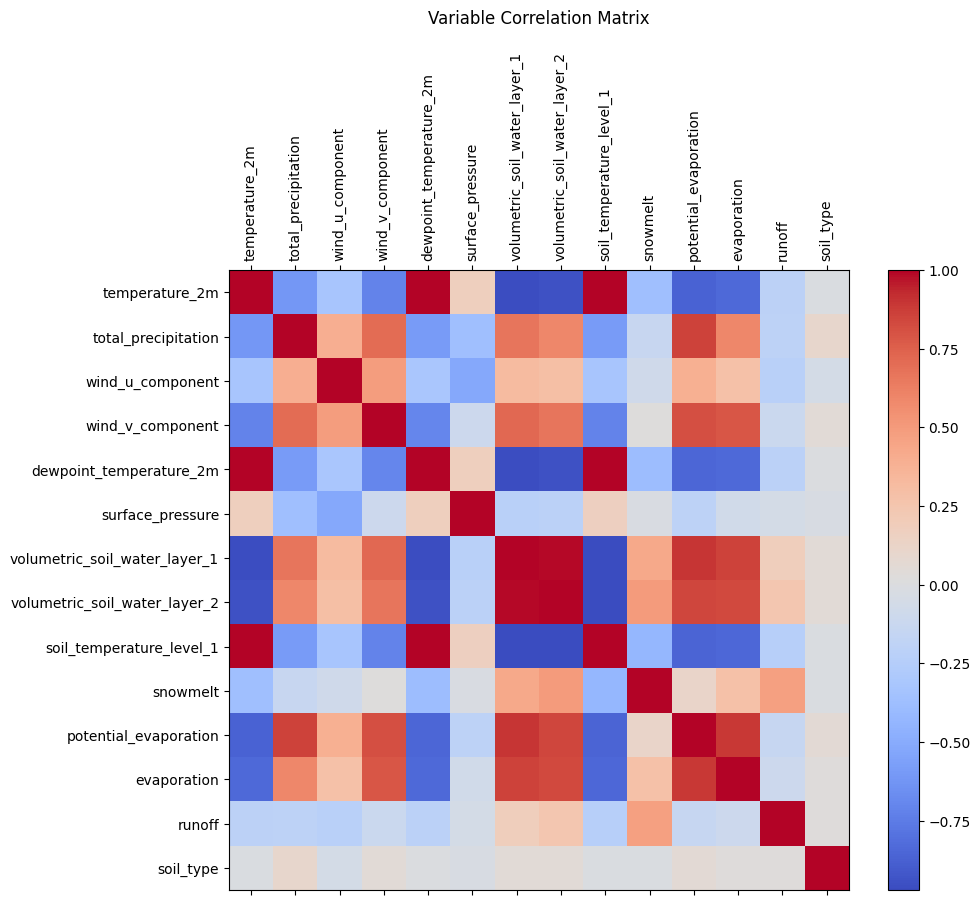


Correlation Matrix:
                               temperature_2m  total_precipitation  \
temperature_2m                       1.000000            -0.612703   
total_precipitation                 -0.612703             1.000000   
wind_u_component                    -0.320791             0.396381   
wind_v_component                    -0.716291             0.707067   
dewpoint_temperature_2m              0.998930            -0.592870   
surface_pressure                     0.173402            -0.366281   
volumetric_soil_water_layer_1       -0.959086             0.663211   
volumetric_soil_water_layer_2       -0.945664             0.590820   
soil_temperature_level_1             0.994207            -0.592447   
snowmelt                            -0.366926            -0.132891   
potential_evaporation               -0.864371             0.855498   
evaporation                         -0.838393             0.585317   
runoff                              -0.201814            -0.196583   

In [71]:
# Step 1: Define Variables of Interest
print("\nStep 1: Exploring variables of interest...")
variables_of_interest = [
    "temperature_2m",
    "total_precipitation",
    "wind_u_component",
    "wind_v_component",
    "dewpoint_temperature_2m",
    "surface_pressure",
    "volumetric_soil_water_layer_1",
    "volumetric_soil_water_layer_2",
    "soil_temperature_level_1",
    "snowmelt",
    "potential_evaporation",
    "evaporation",
    "runoff",
    "soil_type"
]

# Prepare a list to store DataFrames for correlation analysis
data_frames = []

for i, ds in enumerate(processed_datasets):
    print(f"Processing Dataset {i} for correlation analysis...")
    
    # Filter variables of interest that exist in the current dataset
    available_vars = [var for var in variables_of_interest if var in ds]
    print(f"Variables available in Dataset {i}: {available_vars}")
    
    # Skip this dataset if none of the variables of interest are present
    if not available_vars:
        print(f"Dataset {i} contains no variables of interest. Skipping.")
        continue
    
    # Convert variables to DataFrame and store
    selected_vars = {var: ds[var].to_dataframe() for var in available_vars}
    
    # Combine into a single DataFrame
    combined_df = pd.concat(selected_vars.values(), axis=1)
    
    # Align by the time index
    combined_df = combined_df.groupby(level="time").mean()
    
    # Append to the list
    data_frames.append(combined_df)

# Step 2: Combine DataFrames from All Datasets
if data_frames:
    print("\nStep 2: Merging data from all datasets...")
    merged_data = pd.concat(data_frames, axis=1)

    # Drop rows with missing values
    merged_data = merged_data.dropna()
    print(f"Merged data shape: {merged_data.shape}")

    # Select only variables of interest for correlation analysis
    selected_columns = [col for col in variables_of_interest if col in merged_data.columns]
    filtered_data = merged_data[selected_columns]
    print(selected_columns)
    print(f"Filtered data shape: {filtered_data.shape}")

    # Step 3: Compute Correlation Matrix
    print("\nStep 3: Computing correlation matrix...")
    correlation_matrix = filtered_data.corr()

    # Step 4: Visualize Correlation Matrix
    print("\nStep 4: Visualizing correlation matrix...")
    plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=1, cmap="coolwarm")
    plt.colorbar()
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
    plt.title("Variable Correlation Matrix", pad=20)
    plt.show()

    # Print Correlation Matrix
    print("\nCorrelation Matrix:")
    print(correlation_matrix)
else:
    print("\nNo valid data for correlation analysis.")


#### Visualize Relationships Using Scatter Plots or Heatmaps & Check for Lagged Correlations


Step 5: Visualizing pairwise relationships...


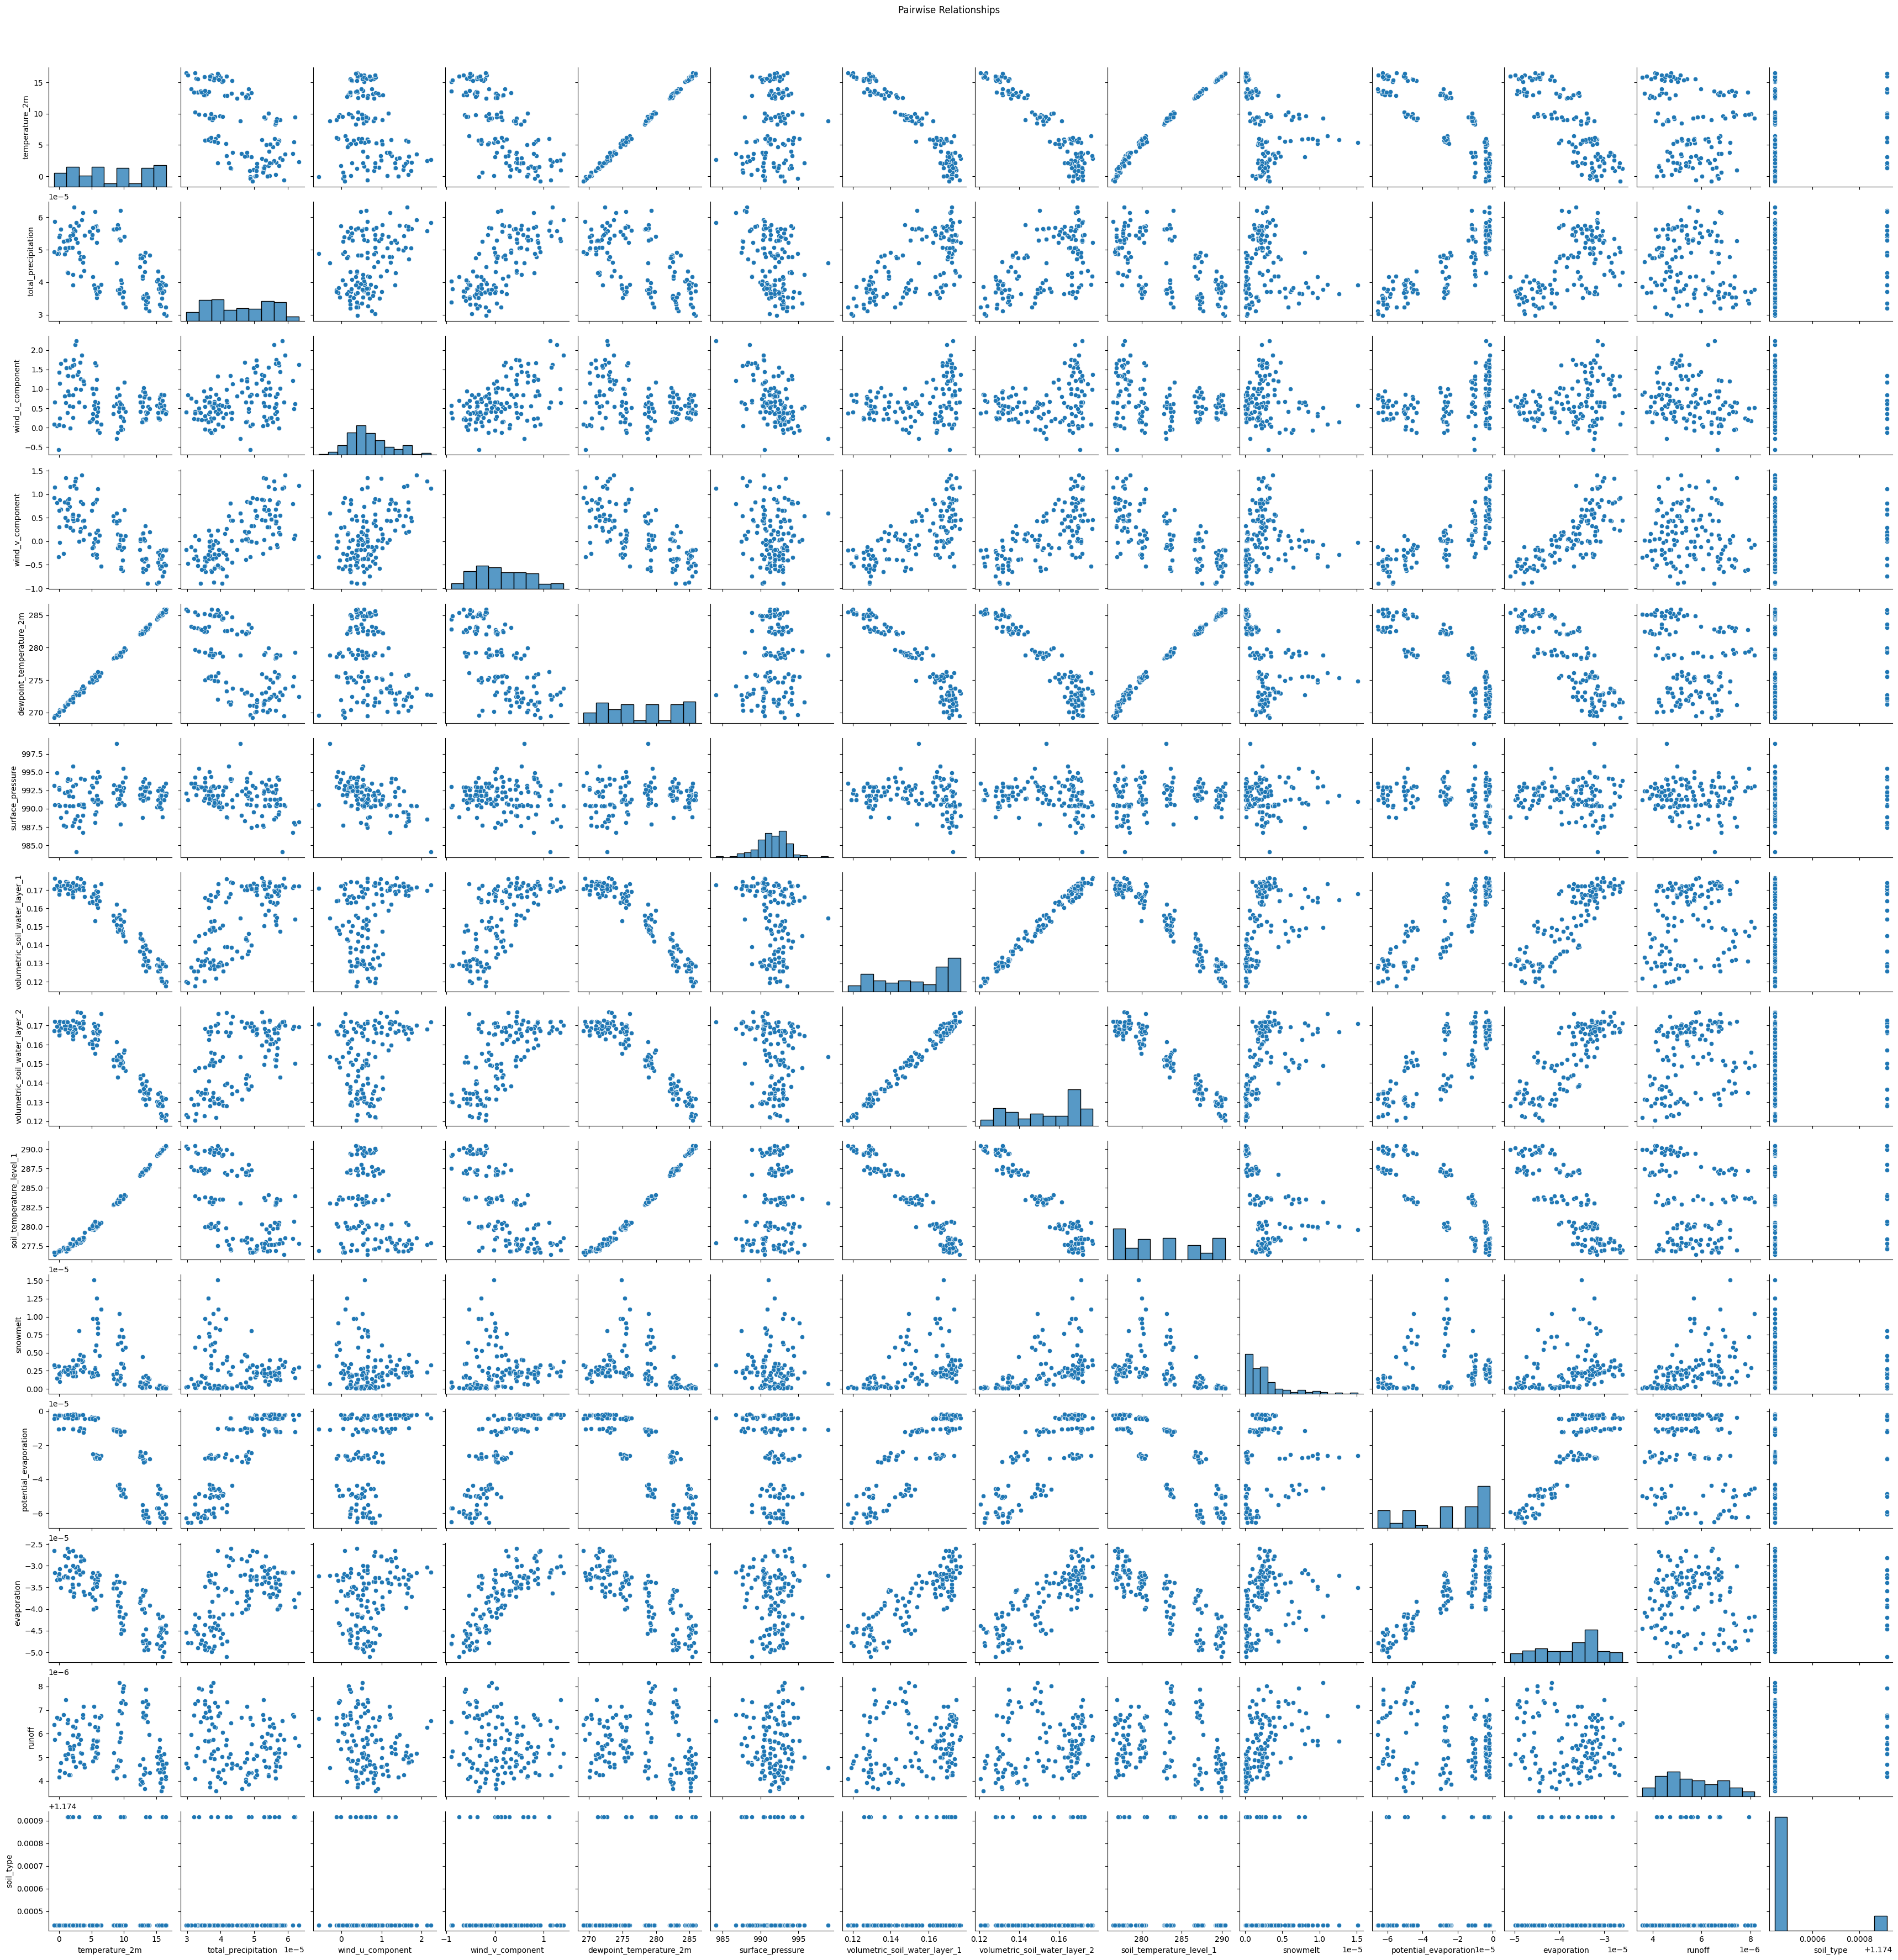


Step 6: Heatmap of the correlation matrix...


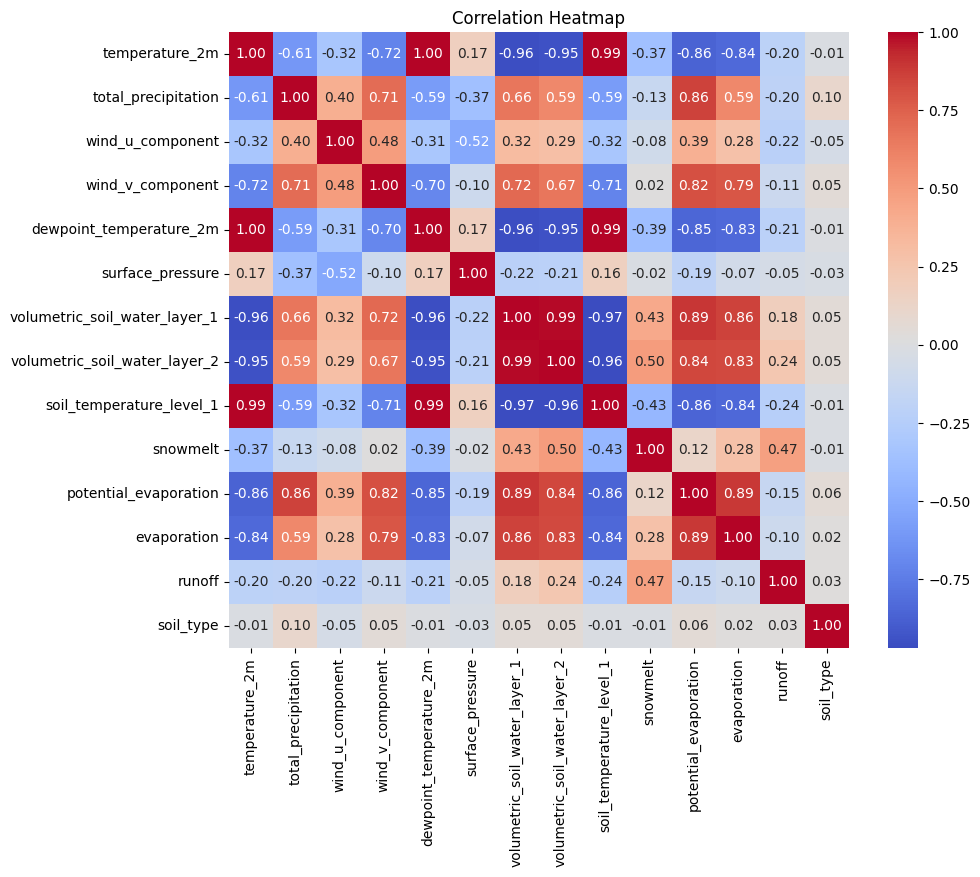


Step 7: Checking for lagged correlations...
Lag 1: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.87
Lag 2: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.83
Lag 3: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.60
Lag 4: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.21
Lag 5: Correlation between total_precipitation and volumetric_soil_water_layer_1 = -0.23
Lag 6: Correlation between total_precipitation and volumetric_soil_water_layer_1 = -0.62


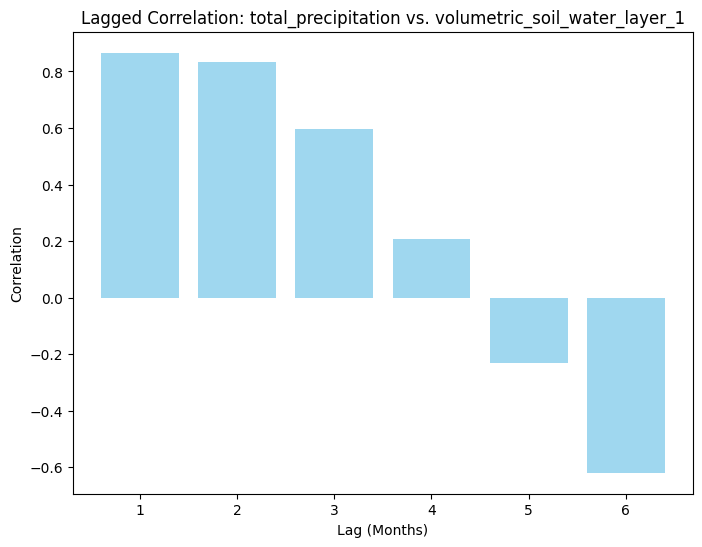

In [72]:
# Step 5: Visualize Relationships Using Scatter Plots and Heatmaps
print("\nStep 5: Visualizing pairwise relationships...")

# Scatter plot for pairwise relationships
sns.pairplot(merged_data[selected_columns])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

# Heatmap for the correlation matrix
print("\nStep 6: Heatmap of the correlation matrix...")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Step 7: Lagged Correlation Analysis
print("\nStep 7: Checking for lagged correlations...")

# Define variables to analyze lagged correlation (e.g., precipitation vs. soil water levels)
lag_variable = "total_precipitation"
response_variable = "volumetric_soil_water_layer_1"

# Maximum number of lags to check
max_lag = 6

# Calculate lagged correlations
lagged_correlations = []
for lag in range(1, max_lag + 1):
    shifted_data = merged_data[lag_variable].shift(lag)  # Shift precipitation data by 'lag' months
    correlation = merged_data[response_variable].corr(shifted_data)
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Visualize lagged correlations
lags, correlations = zip(*lagged_correlations)
plt.figure(figsize=(8, 6))
plt.bar(lags, correlations, color="skyblue", alpha=0.8)
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(lags)
plt.show()


#### Calculate lagged correlations between temperature_2m and volumetric_soil_water_layer_1


Step 7: Checking for lagged correlations...
Lag 1: Correlation between temperature_2m and volumetric_soil_water_layer_1 = -0.79
Lag 2: Correlation between temperature_2m and volumetric_soil_water_layer_1 = -0.40
Lag 3: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.09
Lag 4: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.54
Lag 5: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.84
Lag 6: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.93


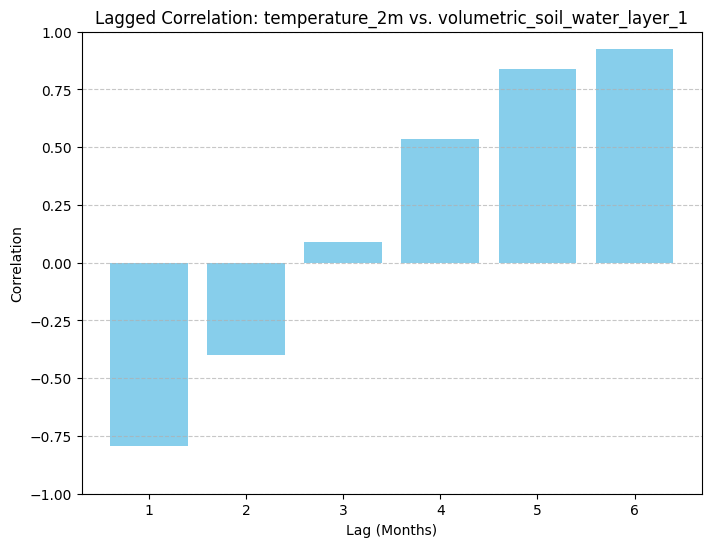

In [66]:
# Define variables for lagged correlation
lag_variable = "temperature_2m"  # Predictor variable
response_variable = "volumetric_soil_water_layer_1"  # Response variable
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep 7: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the temperature data by 'lag' months
    shifted_data = merged_data[lag_variable].shift(lag)
    
    # Compute the correlation with soil water content
    correlation = merged_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Calculate lagged correlations between total_precipitation and runoff (Analyze rainfall impact on runoff)


Step: Checking for lagged correlations...
Lag 1: Correlation between total_precipitation and runoff = 0.09
Lag 2: Correlation between total_precipitation and runoff = 0.34
Lag 3: Correlation between total_precipitation and runoff = 0.53
Lag 4: Correlation between total_precipitation and runoff = 0.57
Lag 5: Correlation between total_precipitation and runoff = 0.49
Lag 6: Correlation between total_precipitation and runoff = 0.30


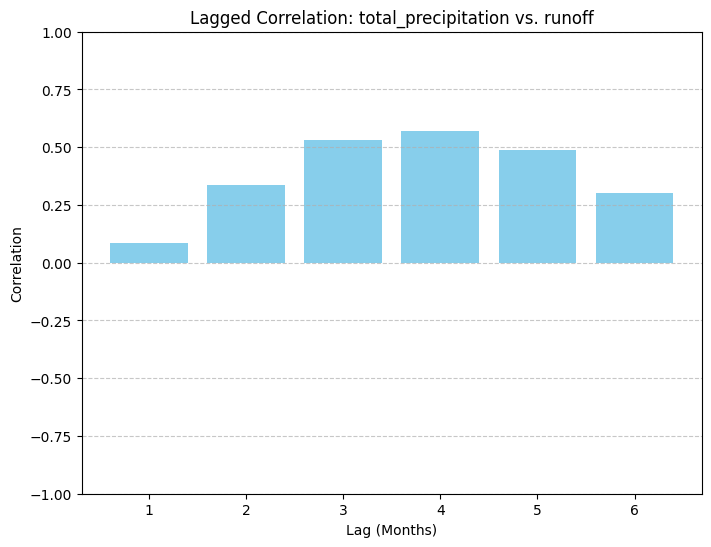

In [73]:
# Variables to analyze lagged correlation
lag_variable = "total_precipitation"  # Predictor variable (rainfall)
response_variable = "runoff"  # Response variable (runoff)
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the predictor variable by 'lag' months
    shifted_data = filtered_data[lag_variable].shift(lag)
    
    # Compute correlation with the response variable
    correlation = filtered_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Calculate lagged correlations between snowmelt and volumetric_soil_water_layer_2 
#### (Analyze snowmelt's delayed effects on deeper soil water)


Step: Checking for lagged correlations...
Lag 1: Correlation between snowmelt and volumetric_soil_water_layer_2 = 0.06
Lag 2: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.36
Lag 3: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.63
Lag 4: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.65
Lag 5: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.46
Lag 6: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.19


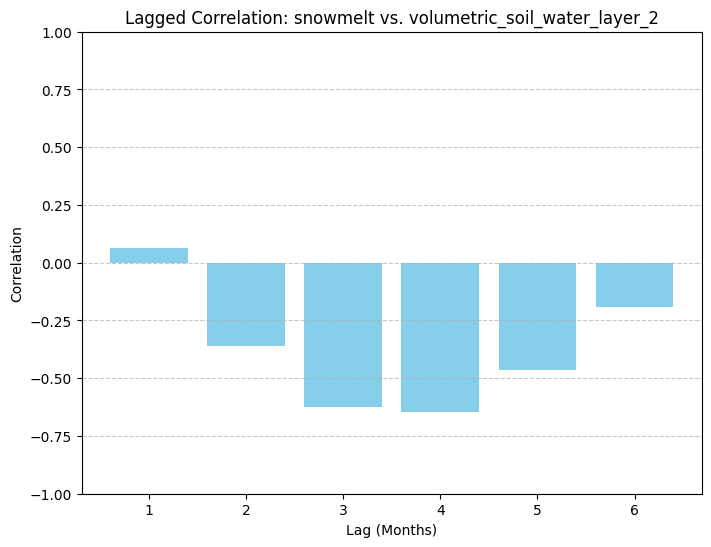

In [74]:
# Variables to analyze lagged correlation
lag_variable = "snowmelt"  # Predictor variable (snowmelt)
response_variable = "volumetric_soil_water_layer_2"  # Response variable (deep soil water)
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the predictor variable by 'lag' months
    shifted_data = filtered_data[lag_variable].shift(lag)
    
    # Compute correlation with the response variable
    correlation = filtered_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Calculate lagged correlations between temperature_2m and potential_evaporation 
#### (Study how temperature impacts evaporation over time)


Step: Checking for lagged correlations...
Lag 1: Correlation between temperature_2m and potential_evaporation = -0.51
Lag 2: Correlation between temperature_2m and potential_evaporation = -0.02
Lag 3: Correlation between temperature_2m and potential_evaporation = 0.46
Lag 4: Correlation between temperature_2m and potential_evaporation = 0.80
Lag 5: Correlation between temperature_2m and potential_evaporation = 0.94
Lag 6: Correlation between temperature_2m and potential_evaporation = 0.84


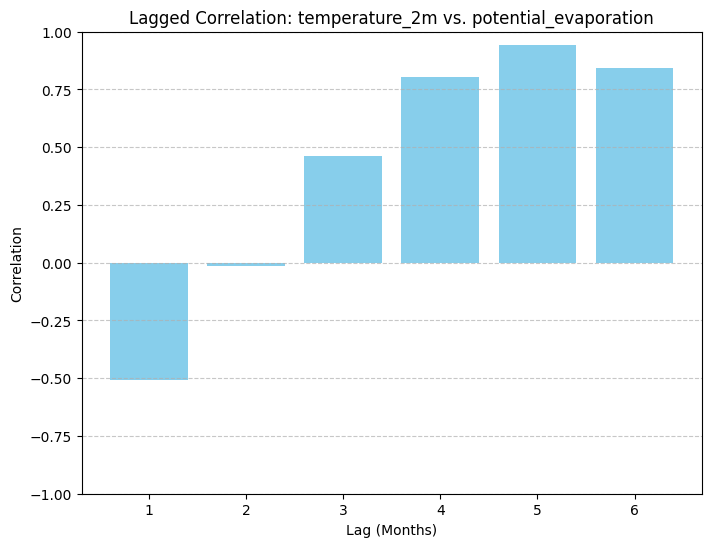

In [75]:
# Variables to analyze lagged correlation
lag_variable = "temperature_2m"  # Predictor variable (temperature)
response_variable = "potential_evaporation"  # Response variable (evaporation potential)
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the predictor variable by 'lag' months
    shifted_data = filtered_data[lag_variable].shift(lag)
    
    # Compute correlation with the response variable
    correlation = filtered_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Trend Analysis


Analyzing trend for: temperature_2m...


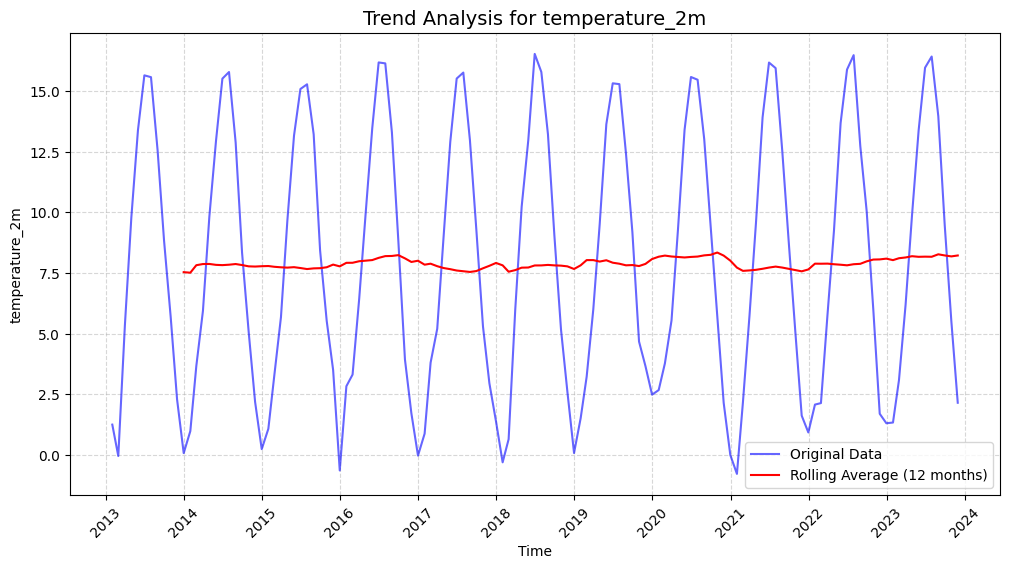


Analyzing trend for: total_precipitation...


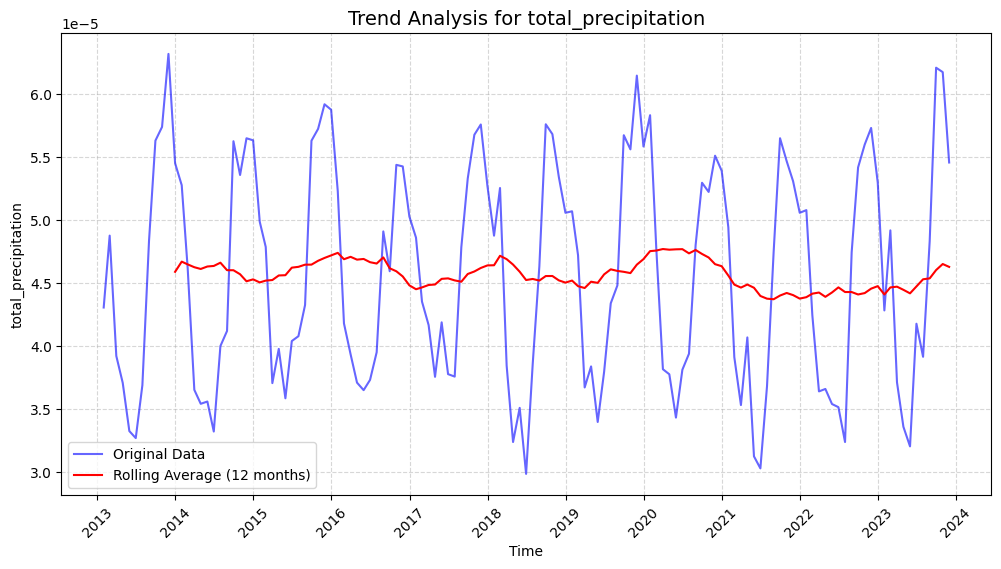


Analyzing trend for: wind_u_component...


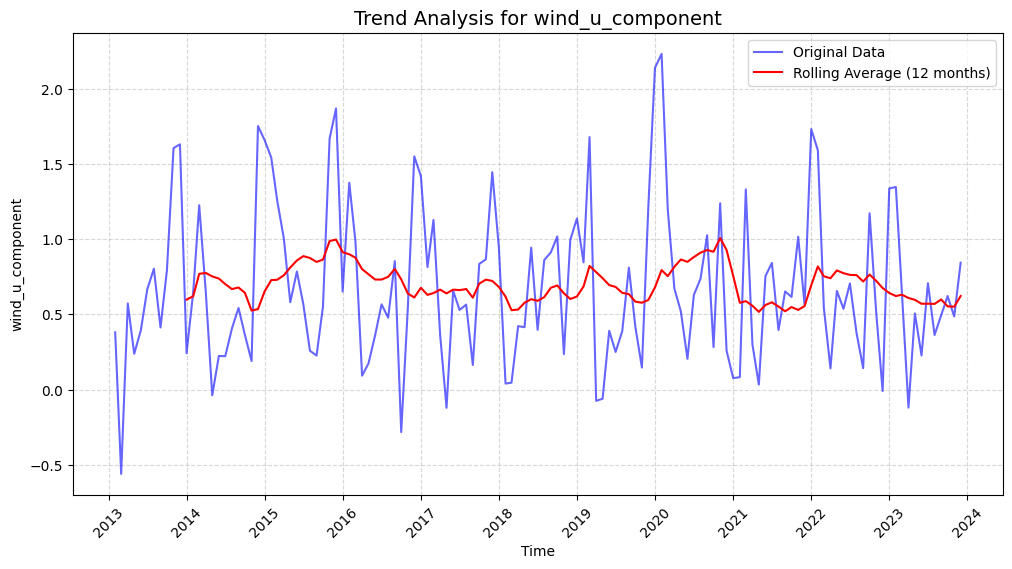


Analyzing trend for: wind_v_component...


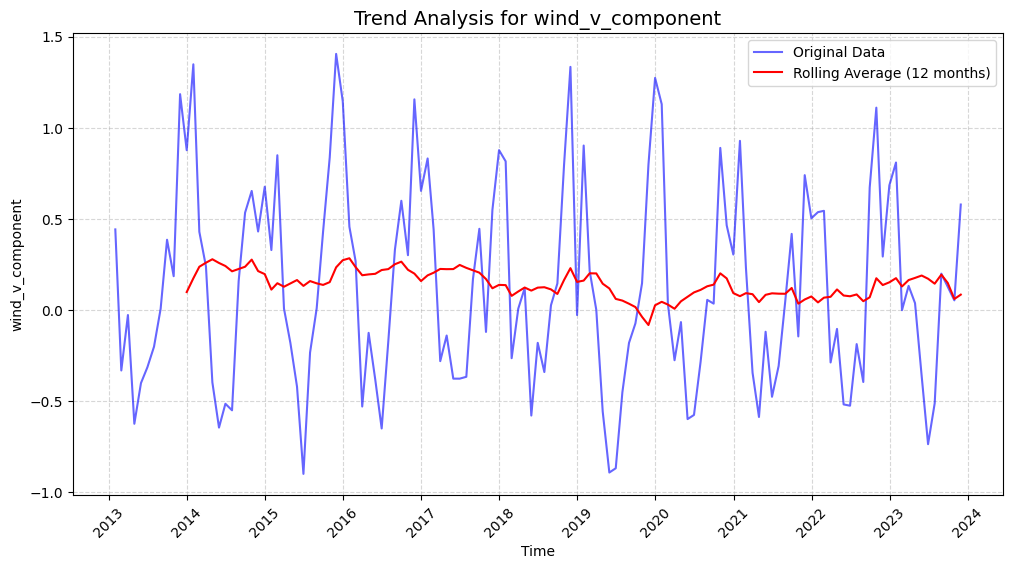


Analyzing trend for: dewpoint_temperature_2m...


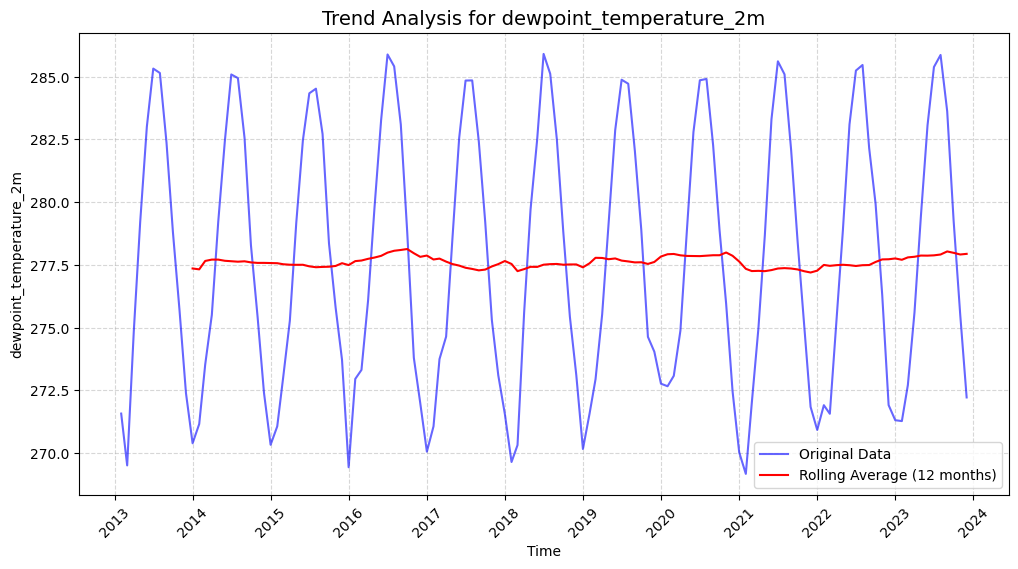


Analyzing trend for: surface_pressure...


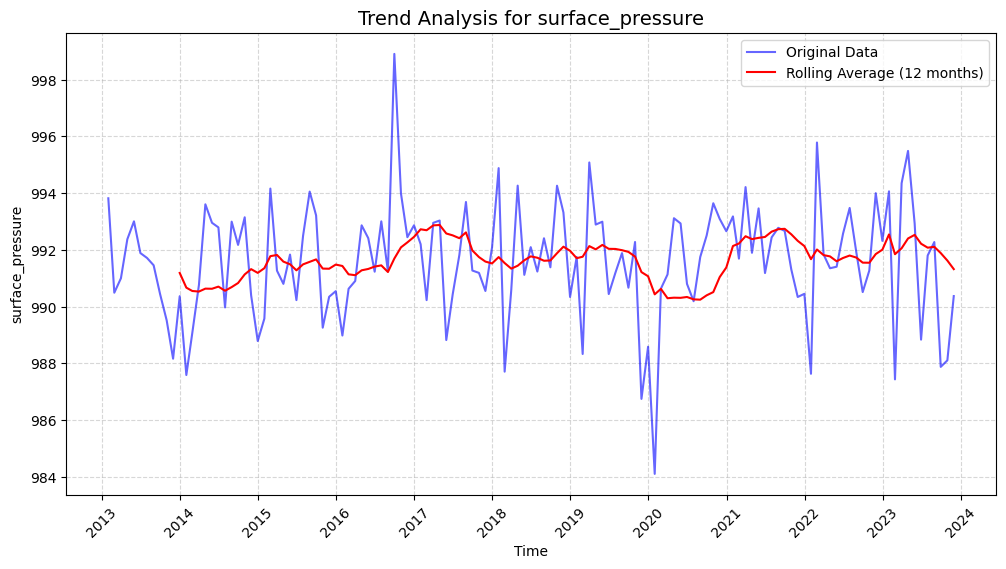


Analyzing trend for: volumetric_soil_water_layer_1...


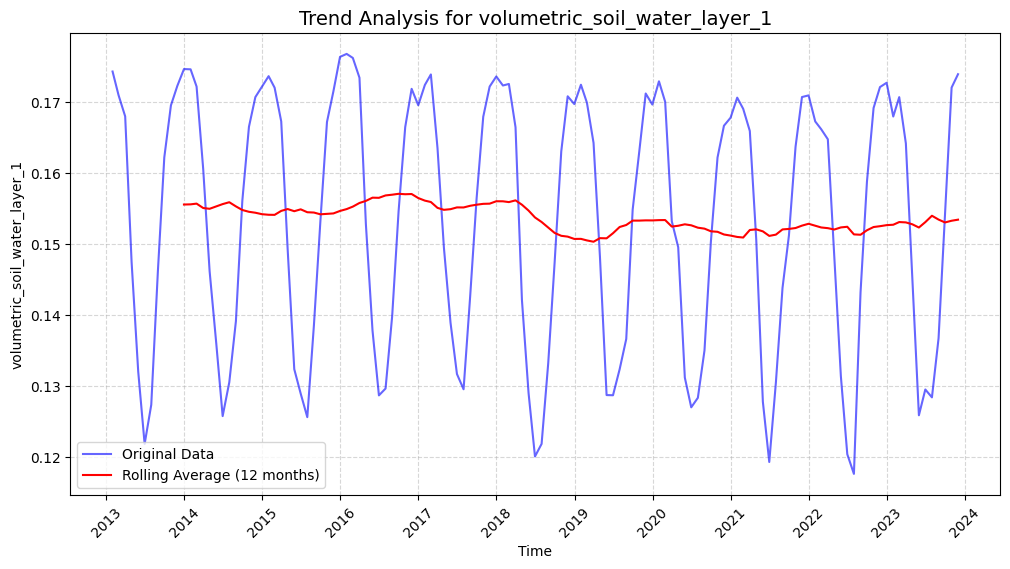


Analyzing trend for: volumetric_soil_water_layer_2...


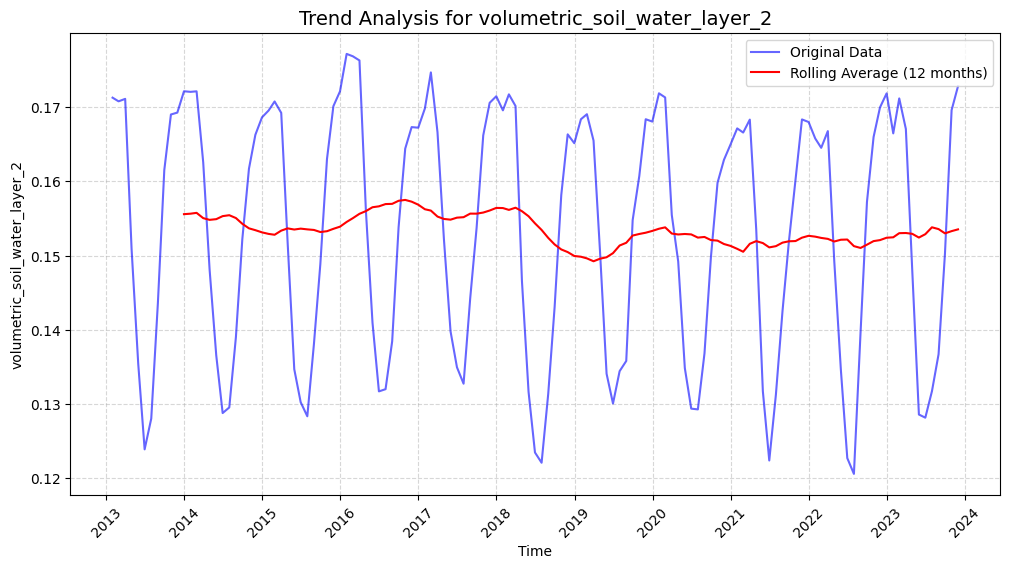


Analyzing trend for: soil_temperature_level_1...


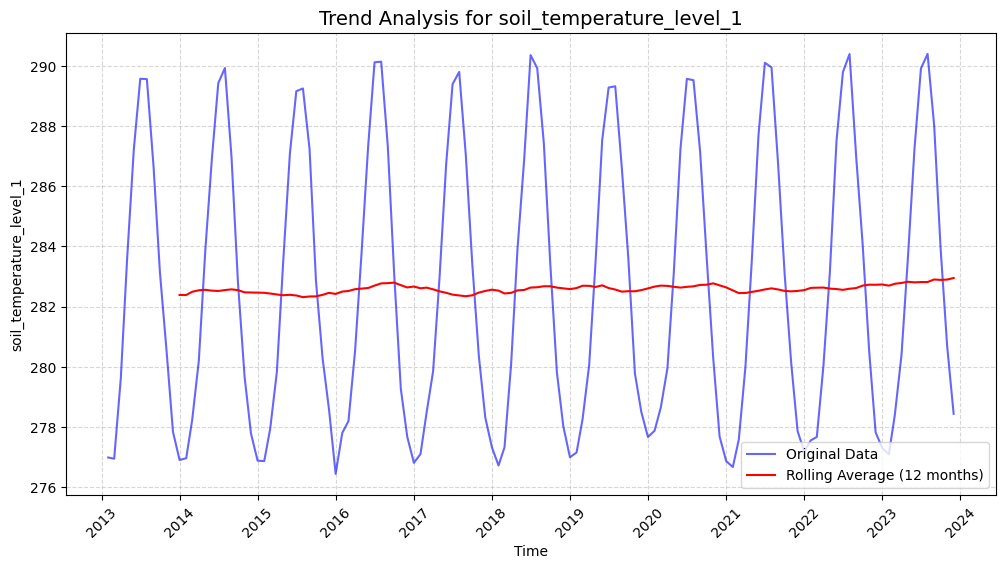


Analyzing trend for: snowmelt...


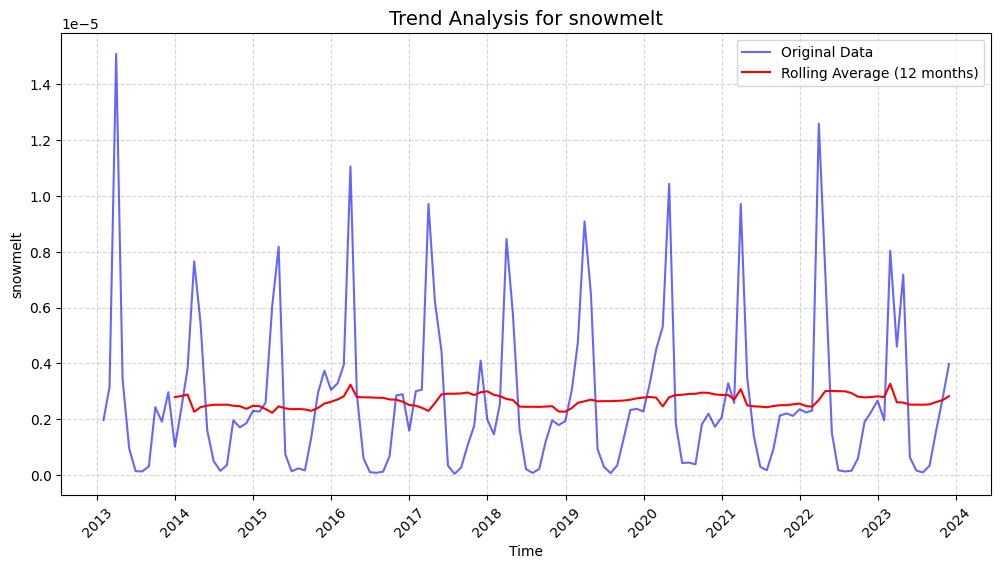


Analyzing trend for: potential_evaporation...


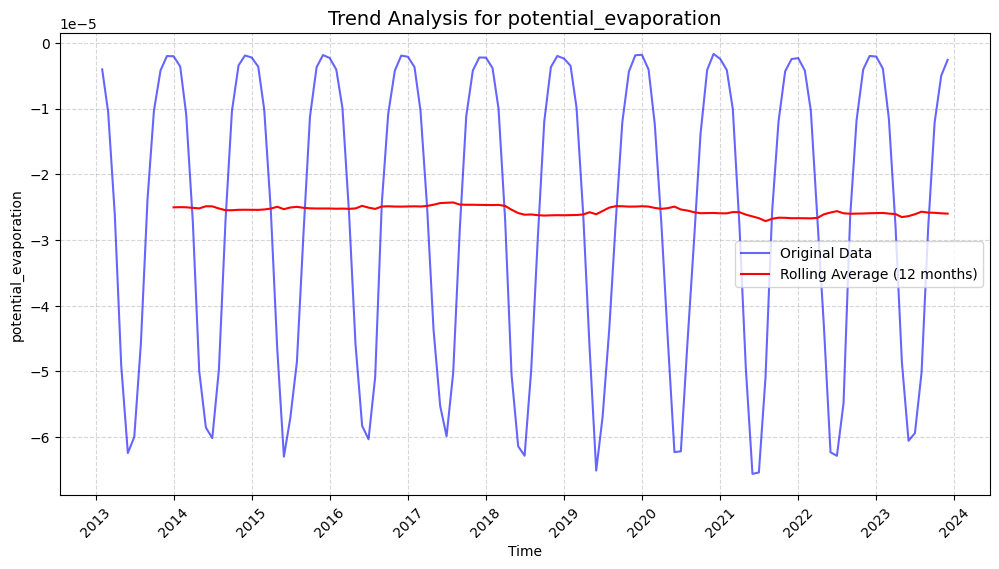


Analyzing trend for: evaporation...


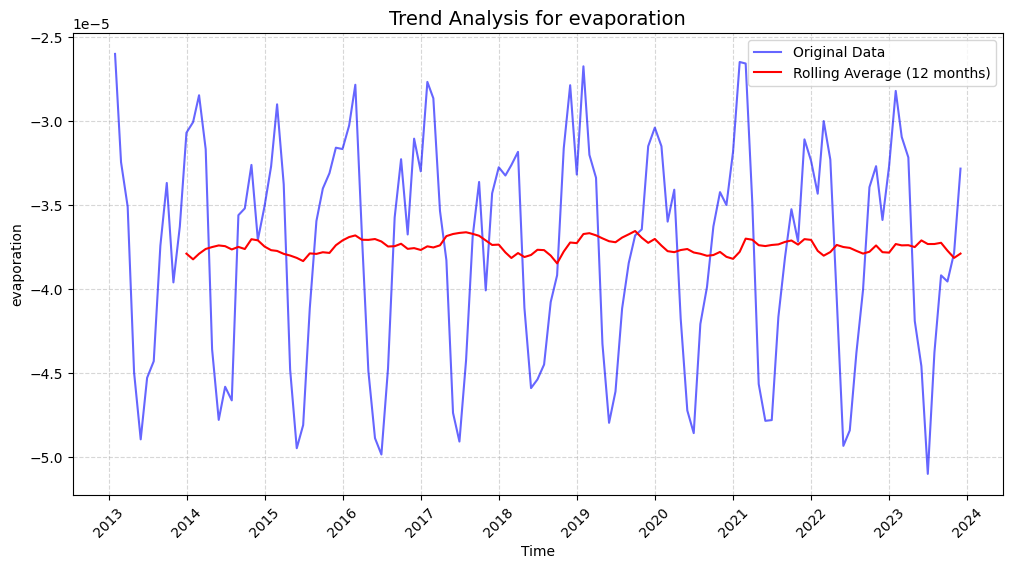


Analyzing trend for: runoff...


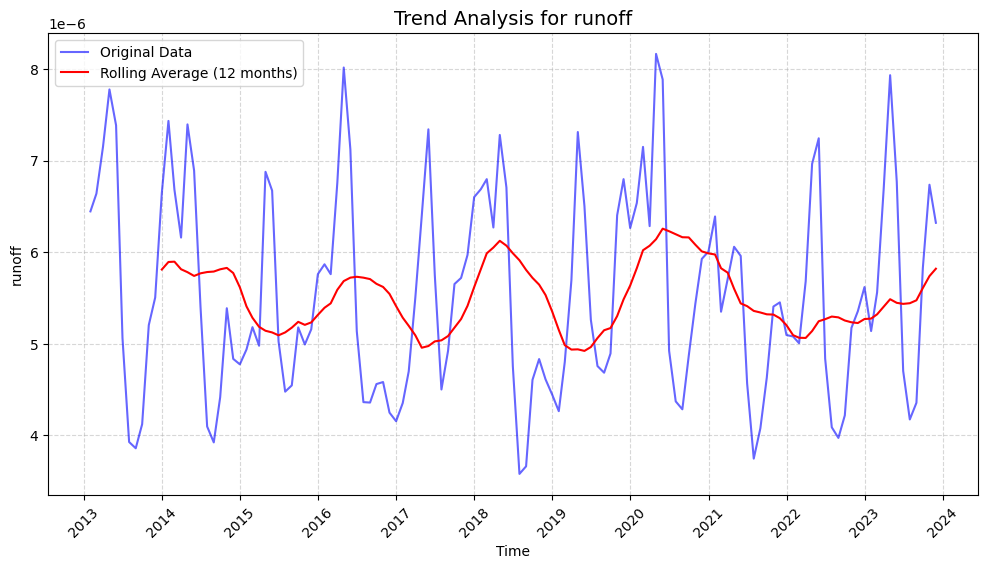


Analyzing trend for: soil_type...


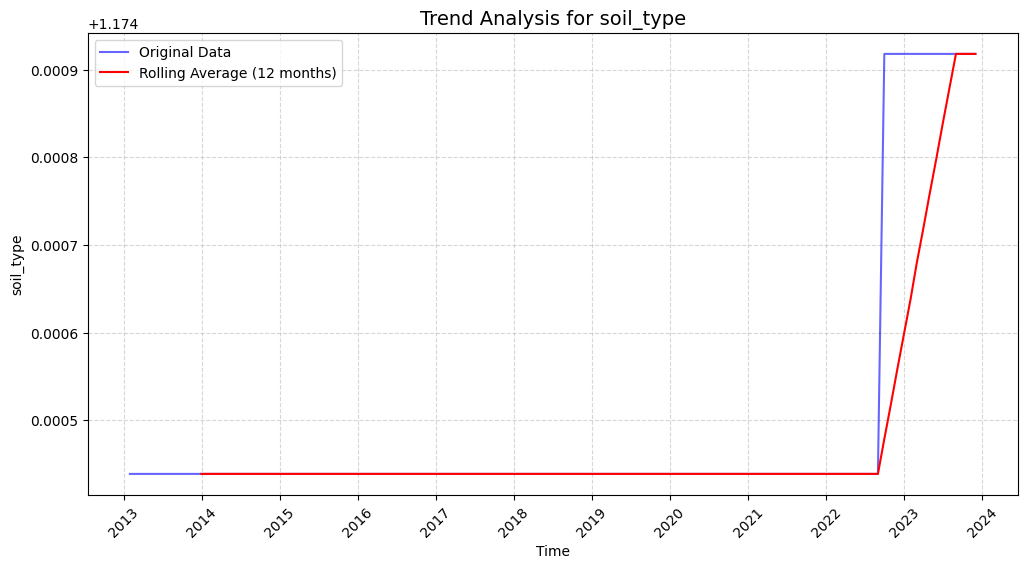

In [82]:

import matplotlib.dates as mdates

# Loop through each variable to analyze trends
for var in variables_of_interest:
    if var in merged_data.columns:
        print(f"\nAnalyzing trend for: {var}...")
        
        # Get the time series for the variable
        time_series = merged_data[var]
        
        # Fill missing values
        time_series = time_series.interpolate(method="linear")
        
        # Calculate a rolling average (12-month moving average)
        rolling_avg = time_series.rolling(window=12).mean()
        
        # Plot the original data and rolling average
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, label="Original Data", color="blue", alpha=0.6)
        plt.plot(rolling_avg, label="Rolling Average (12 months)", color="red")
        
        # Add title and labels
        plt.title(f"Trend Analysis for {var}", fontsize=14)
        plt.xlabel("Time")
        plt.ylabel(var)
        
        # Format x-axis to show years
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)  # Rotate year labels
        
        # Add grid and legend
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        
        # Show the plot
        plt.show()
    else:
        print(f"Variable '{var}' not found in the dataset.")



### Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2013-2020

#### Combine Datasets & Cleaning 

In [12]:

folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2013-2020"

# Find all .nc files in the folder
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".nc")]

# Fix the 'step' dimension and ensure it's unique
def preprocess(ds):
    if "step" in ds.coords and "valid_time" in ds.coords:
        # Replace 'step' with 'valid_time'
        ds = ds.assign_coords(step=("step", ds["valid_time"].values))
    
    # Deduplicate or aggregate 'step'
    if "step" in ds.coords:
        # Remove duplicates, keeping the first occurrence
        _, index = np.unique(ds["step"], return_index=True)
        # ds = ds.isel(step=index) 
        ds = ds.groupby("step").mean()
    return ds

# Categorize files by member size
files_by_member_size = {25: [], 51: []}

for file in file_list:
    ds = xr.open_dataset(file)
    member_size = ds.sizes.get('member', None)
    if member_size == 25:
        files_by_member_size[25].append(file)
    elif member_size == 51:
        files_by_member_size[51].append(file)

# Combine datasets
combined_datasets = {}

for member_size, files in files_by_member_size.items():
    if files:
        # Use open_mfdataset to process files and reduce memory usage
        
        # Chunking divides the dataset into manageable parts based on one or more dimensions
        # Each "chunk" is a smaller portion of the dataset, and operations are performed on these
        # chunks sequentially or in parallel, which helps reduce memory usage and allows processing 
        # of datasets that are too large to fit into RAM.
        ds = xr.open_mfdataset(
            files,
            preprocess=preprocess,
            combine="nested", #assumes that the files are ordered logically in the same way as the desired concatenation order
            concat_dim="member",
            chunks={"step": 10}  
        )
        
        # Sort the dataset by 'step' in ascending order
        ds = ds.sortby("step", ascending=True)

        
        # Fill missing values
        ds = ds.fillna(float("nan"))  # Replace missing data with NaN
        print(f"Filled missing values for dataset with {member_size} members.")

        # Validate data ranges
        if "discharge" in ds.variables:  # Ensure river discharge is non-negative
            ds["discharge"] = ds["discharge"].where(ds["discharge"] >= 0, float("nan"))
            print("Validated river discharge values (>= 0).")

        if "temperature" in ds.variables:  # Ensure temperature is within a realistic range
            ds["temperature"] = ds["temperature"].where((ds["temperature"] >= 200) & (ds["temperature"] <= 350), float("nan"))
            print("Validated temperature range (200K to 350K).")

        # Convert units
        if "temperature" in ds.variables:  # Convert temperature from Kelvin to Celsius
            ds["temperature"] = ds["temperature"] - 273.15
            print("Converted temperature to Celsius.")

        if "precipitation" in ds.variables:  # Convert precipitation to millimeters
            ds["precipitation"] = ds["precipitation"] * 1000
            print("Converted precipitation to millimeters.")

        # Rename variables for clarity
        rename_dict = {
            "discharge": "river_discharge",
            "temperature": "air_temperature",
            "precipitation": "total_precipitation"
        }
        existing_vars = set(ds.variables)  # Get all variables in the dataset
        rename_vars = {k: v for k, v in rename_dict.items() if k in existing_vars}  # Find variables to rename
        ds = ds.rename(rename_vars)  # Apply the renaming
        print("Renamed variables for clarity.")

        # Update metadata
        for var in ds.data_vars:  # Add descriptions to all variables
            ds[var].attrs["description"] = f"Cleaned variable: {var}"
        print("Updated metadata.")

        
        combined_datasets[member_size] = ds
        print(f"Combined dataset with {member_size} members:")
        print(ds)
    else:
        print(f"No datasets found with {member_size} members.")


Filled missing values for dataset with 25 members.
Renamed variables for clarity.
Updated metadata.
Combined dataset with 25 members:
<xarray.Dataset> Size: 1TB
Dimensions:                       (step: 54, y: 950, x: 1000, member: 1200)
Coordinates:
  * y                             (y) float64 8kB 5.498e+06 ... 7.525e+05
  * x                             (x) float64 8kB 2.502e+06 ... 7.498e+06
  * step                          (step) datetime64[ns] 432B 2013-01-31 ... 2...
    number                        (member) int64 10kB dask.array<chunksize=(25,), meta=np.ndarray>
Dimensions without coordinates: member
Data variables:
    rdis                          (step, y, x, member) float32 246GB dask.array<chunksize=(1, 950, 1000, 25), meta=np.ndarray>
    latitude                      (member, step, y, x) float32 246GB dask.array<chunksize=(25, 1, 950, 1000), meta=np.ndarray>
    longitude                     (member, step, y, x) float32 246GB dask.array<chunksize=(25, 1, 950, 1000), met

### Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023

#### See Dimension of Dataset

In [13]:

folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023"

# Get the list of all .nc files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".nc")]

# Go through each file and show its dimensions
for idx, file_path in enumerate(file_list):
    try:
        # Open the dataset
        ds = xr.open_dataset(file_path)
        
        # Print the file name and its dimensions
        print(f"Dataset {idx + 1}: {os.path.basename(file_path)}")
        print(ds.dims)  # Show dataset dimensions
        print("-" * 40)  # Add a separator for clarity

        
        # Close the dataset to free space in memory
        ds.close()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")


Dataset 1: fairCRPSS_seas5_EFAS_01_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 2: fairCRPSS_seas5_EFAS_02_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 3: fairCRPSS_seas5_EFAS_03_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 4: fairCRPSS_seas5_EFAS_04_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 5: fairCRPSS_seas5_EFAS_05_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 6: fairCRPSS_seas5_EFAS_06_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 7: fairCRPSS_seas5_E

#### Combine Datasets & Cleaning 

In [14]:

# Path to the folder with all .nc files
folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023"

# Get a list of all .nc files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".nc")]

# Function to clean and prepare each dataset
def preprocess(ds):
    # Make sure 'longitude' and 'latitude' are treated as coordinates
    if "longitude" not in ds.coords and "longitude" in ds.variables:
        ds = ds.set_coords("longitude")
    if "latitude" not in ds.coords and "latitude" in ds.variables:
        ds = ds.set_coords("latitude")

    # If 'step' is missing, create it from 'time'
    if "step" not in ds.sizes and "time" in ds.sizes:
        ds["step"] = ("time", np.arange(ds.sizes["time"]))  # Add step values
        ds = ds.swap_dims({"time": "step"})  # Use 'step' instead of 'time'

    # Convert 'step' values to days
    if "step" in ds.coords:
        step_values = ds["step"].values
        step_values_in_days = (step_values - step_values.min()) / (60 * 60 * 24 * 1e9)  # Convert to days
        ds = ds.assign_coords(step=("step", step_values_in_days.astype("float64")))
        ds = ds.sortby("step")  # Sort steps by value

    # Replace missing values with 0
    ds = ds.fillna(0)

    # Remove duplicate steps
    if "step" in ds.dims:
        _, index = np.unique(ds["step"], return_index=True)
        ds = ds.isel(step=index)

    # Make sure values are within reasonable ranges
    for var in ds.data_vars:
        ds[var] = ds[var].clip(min=0)  # Set all negative values to 0

    # Remove outliers (extreme values)
    for var in ds.data_vars:
        if isinstance(ds[var].data, np.ndarray):  # Only apply if not using dask
            lower = ds[var].quantile(0.01).compute()
            upper = ds[var].quantile(0.99).compute()
            ds[var] = ds[var].where((ds[var] >= lower) & (ds[var] <= upper), np.nan)

    # Make sure latitude and longitude values are valid
    if "latitude" in ds.coords and "longitude" in ds.coords:
        valid_lat = (ds["latitude"] >= -90) & (ds["latitude"] <= 90)
        valid_lon = (ds["longitude"] >= -180) & (ds["longitude"] <= 180)
        ds = ds.where(valid_lat.compute() & valid_lon.compute(), drop=True)  # Keep only valid coordinates

    # Add metadata to show the dataset was cleaned
    ds.attrs["processed"] = "True"
    ds.attrs["description"] = "Cleaned dataset with missing values fixed and outliers removed."

    return ds

# Function to combine multiple datasets into one
def combine_datasets(files):
    try:
        # Open and combine datasets
        combined = xr.open_mfdataset(
            files,
            preprocess=preprocess,  # Clean each dataset before combining
            combine="by_coords",    # Match datasets by their coordinates
            chunks={}               # Avoid chunking issues
        )
        # Fix chunking along spatial dimensions to avoid errors
        combined = combined.chunk({"y": -1, "x": -1})
        print("Datasets combined successfully!")
        return combined
    except Exception as e:
        print(f"Error combining datasets: {e}")
        return None

# Combine the first half of the datasets
ds_combined1 = combine_datasets(file_list[:16])  # Process the first set of files
if ds_combined1:
    print("First combined dataset:")
    print(ds_combined1)

# Combine the second half of the datasets
ds_combined2 = combine_datasets(file_list[16:])  # Process the second set of files
if ds_combined2:
    print("Second combined dataset:")
    print(ds_combined2)





Datasets combined successfully!
First combined dataset:
<xarray.Dataset> Size: 5GB
Dimensions:                       (time: 1, y: 950, x: 1000, step: 24,
                                   member: 51)
Coordinates:
  * time                          (time) datetime64[ns] 8B 2016-01-01
  * y                             (y) int32 4kB 5497500 5492500 ... 752500
  * x                             (x) int32 4kB 2502500 2507500 ... 7497500
  * step                          (step) float64 192B -8.031e+04 ... 9.956e+04
    latitude                      (y, x) float32 4MB dask.array<chunksize=(950, 1000), meta=np.ndarray>
    longitude                     (y, x) float32 4MB dask.array<chunksize=(950, 1000), meta=np.ndarray>
    number                        (member) int64 408B dask.array<chunksize=(51,), meta=np.ndarray>
    valid_time                    (step) datetime64[ns] 192B dask.array<chunksize=(7,), meta=np.ndarray>
Dimensions without coordinates: member
Data variables:
    fairCRPSS      

### Climate_indicators_for_Europe_from_2013_to_2023_derived_from_reanalysis

#### Combine Datasets

In [15]:
folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Climate_indicators_for_Europe_from_2013_to_2023_derived_from_reanalysis"

# Find all .nc files in the folder
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".nc")]

# Open and combine multiple datasets using nested merging
combined_dataset = xr.open_mfdataset(file_list, combine='nested', concat_dim='step', coords='minimal')
# Combine files in order
# Merge along the 'step' dimension
# Use only needed coordinates

print("Datasets combined successfully!")


Datasets combined successfully!


#### Data Cleaning

In [16]:
# Fill missing values
combined_dataset = combined_dataset.fillna(float("nan"))  # Replace missing values with NaN
print("Filled missing values.")

# Validate data ranges. 
if "temperature" in combined_dataset.variables:
    # Most global atmospheric temperatures fall between 200 K (-73°C) and 350 K (77°C)
    combined_dataset["temperature"] = combined_dataset["temperature"].where(
        (combined_dataset["temperature"] >= 200) & (combined_dataset["temperature"] <= 350), float("nan")
    )
    print("Validated temperature range (200K to 350K).")

if "precipitation" in combined_dataset.variables:
    # Precipitation cannot be negative
    combined_dataset["precipitation"] = combined_dataset["precipitation"].where(
        combined_dataset["precipitation"] >= 0, float("nan")
    )
    print("Validated precipitation (>= 0).")

# Convert units
if "temperature" in combined_dataset.variables:
    # Convert temperature from Kelvin to Celsius
    combined_dataset["temperature"] = combined_dataset["temperature"] - 273.15
    combined_dataset["temperature"].attrs["units"] = "Celsius"
    print("Converted temperature to Celsius.")

if "precipitation" in combined_dataset.variables:
     # Convert precipitation to millimeters
    combined_dataset["precipitation"] = combined_dataset["precipitation"] * 1000
    combined_dataset["precipitation"].attrs["units"] = "mm"
    print("Converted precipitation to millimeters.")

# Rename variables for clarity
# Example rename dictionary
rename_dict = {
    "temperature": "air_temperature",
    "precipitation": "total_precipitation",
    "discharge": "river_discharge"
}
# Get all variables in the dataset
existing_vars = set(combined_dataset.variables)
# Find variables to rename
rename_vars = {k: v for k, v in rename_dict.items() if k in existing_vars}
combined_dataset = combined_dataset.rename(rename_vars)
print("Renamed variables for clarity.")

# Update metadata
# Add descriptions to each variable
for var in combined_dataset.data_vars:
    combined_dataset[var].attrs["description"] = f"Cleaned variable: {var}"
print("Updated metadata.")

# Print the summary of the cleaned dataset
print("\nCleaned Dataset Summary:")
print(combined_dataset)


Filled missing values.
Renamed variables for clarity.
Updated metadata.

Cleaned Dataset Summary:
<xarray.Dataset> Size: 36GB
Dimensions:      (step: 20, time: 1008, lat: 185, lon: 271)
Coordinates:
  * time         (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2023-12-01
  * lat          (lat) float64 1kB 26.5 26.75 27.0 27.25 ... 72.0 72.25 72.5
  * lon          (lon) float64 2kB -22.0 -21.75 -21.5 -21.25 ... 45.0 45.25 45.5
    realization  int64 8B 0
Dimensions without coordinates: step
Data variables:
    t2m          (step, time, lat, lon) float64 8GB dask.array<chunksize=(1, 1008, 185, 271), meta=np.ndarray>
    data         (step, time, lat, lon) float64 8GB dask.array<chunksize=(1, 1008, 185, 271), meta=np.ndarray>
    tp           (step, time, lat, lon) float32 4GB dask.array<chunksize=(1, 1008, 185, 271), meta=np.ndarray>
    cdd          (step, time, lat, lon) float64 8GB dask.array<chunksize=(1, 1008, 185, 271), meta=np.ndarray>
    fwi          (step, time, lat, lon

#### See Dimension of Dataset

In [17]:
folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023"

# Get the list of all .nc files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".nc")]

# Loop through each file and print its dimensions
for idx, file_path in enumerate(file_list):
    try:
        # Open the dataset
        ds = xr.open_dataset(file_path)
        
        # Print the Dataset name and its dimensions
        print(f"Dataset {idx + 1}: {os.path.basename(file_path)}")
        print(ds.dims)  # Show dataset dimensions
        print("-" * 40)  # Add a separator for clarity
        
         # Close the dataset to save memory
        ds.close()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

Dataset 1: fairCRPSS_seas5_EFAS_01_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 2: fairCRPSS_seas5_EFAS_02_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 3: fairCRPSS_seas5_EFAS_03_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 4: fairCRPSS_seas5_EFAS_04_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 5: fairCRPSS_seas5_EFAS_05_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 6: fairCRPSS_seas5_EFAS_06_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 7: fairCRPSS_seas5_E